# Step 1: Setting the environment

In [40]:
# Import required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, decomposition
from scipy import stats
import statsmodels.api as sm

In [41]:
# Clean VCF

vcf_path = f"data/genotypes.vcf"
ann_path = f"data/annotations.txt"

# Get headers
with open(vcf_path, "r") as f:
    for line in f:
        if line.startswith("#CHROM"):
            header = line.strip().lstrip("#").split("\t")
            break

# Load VCF
vcf_df = pd.read_csv(
    vcf_path,
    sep="\t",
    comment="#",
    header=None,
    names=header,
    low_memory=False
)

# Non-sample columns
fixed_cols = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]

# Sample columns (all individuals)
sample_cols = [col for col in vcf_df.columns if col not in fixed_cols]

# Remove everything except the first item before ':'
for col in sample_cols:
    vcf_df[col] = vcf_df[col].astype(str).str.split(":").str[0]

vcf_df.to_csv("cleaned_genotypes.tsv", sep="\t", index=False)


## 1a. Exploratory data analysis

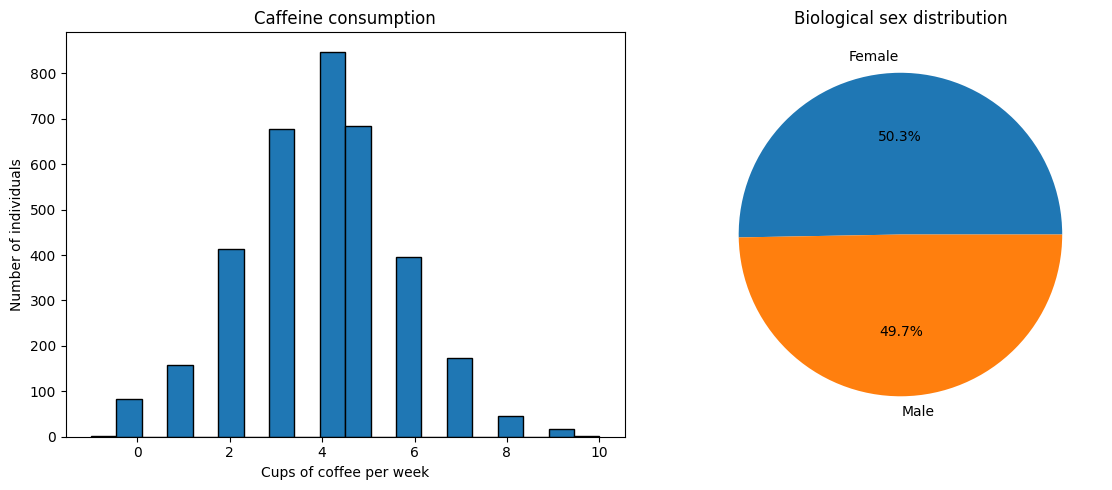

In [42]:
# Plot histogram of caffeine consumption and pie chart for distribution of biological sex

annotations = pd.read_csv(ann_path, sep="\t")
annotations.head()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Histogram of caffeine consumption
axes[0].hist(annotations["CaffeineConsumption"], bins=20, edgecolor="black")
axes[0].set_xlabel("Cups of coffee per week")
axes[0].set_ylabel("Number of individuals")
axes[0].set_title("Caffeine consumption")

# Right: pie chart with Male/Female labels
sex_counts = annotations["isFemale"].value_counts()

axes[1].pie(
    sex_counts,
    labels=[("Female" if str(x).lower() == "true" else "Male") for x in sex_counts.index],
    autopct="%1.1f%%"
)
axes[1].set_title("Biological sex distribution")

plt.tight_layout()
plt.show()

# Step 2: SNP-level filtering - call rate

## 2a. Calculate call rate for each SNP and plot histogram of call rates

In [43]:
# Calculate call rate for each SNP

#Identify sample genotype columns
fixed_cols = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]
sample_cols = [col for col in vcf_df.columns if col not in fixed_cols]

# Compute call rate
is_called = (vcf_df[sample_cols] != "./.")
call_rate = is_called.sum(axis=1) / len(sample_cols)
vcf_df = vcf_df.copy()
vcf_df["call_rate"] = call_rate

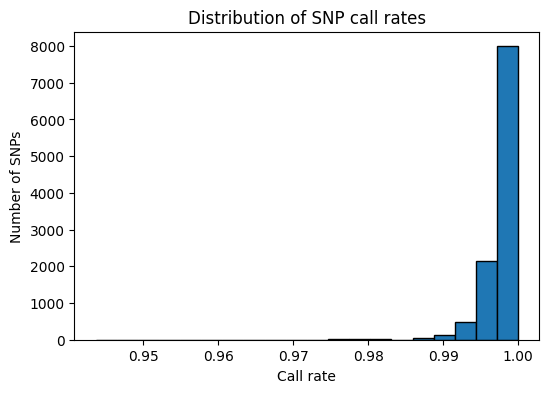

In [44]:
# Plot histogram of call rates

plt.figure(figsize=(6,4))
plt.hist(call_rate, bins=20, edgecolor="black")
plt.xlabel("Call rate")
plt.ylabel("Number of SNPs")
plt.title("Distribution of SNP call rates")
plt.show()

In [45]:
# Keep variants with call rate = 1.0

vcf_filtered = vcf_df[vcf_df["call_rate"] == 1.0]
num_removed = len(vcf_df) - len(vcf_filtered)
print("Number of removed variants due to incomplete data: " + str(num_removed))

Number of removed variants due to incomplete data: 2888


# Step 3: SNP-level filtering - minor allele frequency (MAF)

## 3a. Calculate MAF for each SNP and plot histogram of MAFs for all SNPs

In [46]:
def gt_to_num(gt):
    if gt == "0/0":
        return 0
    elif gt in ["0/1", "1/0"]:
        return 1
    elif gt == "1/1":
        return 2
    else:
        return np.nan

In [47]:
# Calculate MAF for each SNP

# Convert GT to numeric
geno_numeric = vcf_filtered[sample_cols].map(gt_to_num)

# Allele frequency
allele_count = geno_numeric.sum(axis=1)
called = geno_numeric.notna().sum(axis=1)
allele_total = 2 * called
freq = allele_count / allele_total

# Minor allele frequency
maf = np.where(freq <= 0.5, freq, 1 - freq)
vcf_filtered = vcf_filtered.copy()
vcf_filtered["MAF"] = maf

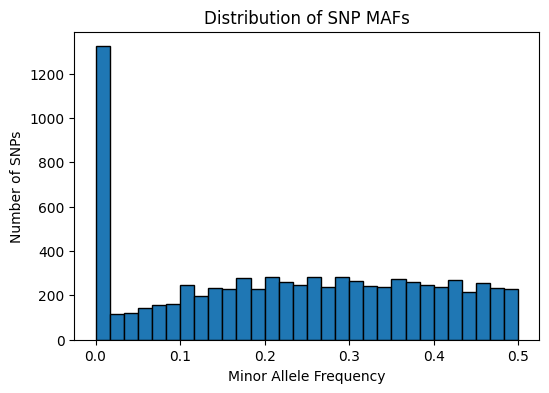

In [48]:
# Plot histogram of all MAFs for all SNPs

plt.figure(figsize=(6,4))
plt.hist(maf, bins=30, edgecolor="black")
plt.xlabel("Minor Allele Frequency")
plt.ylabel("Number of SNPs")
plt.title("Distribution of SNP MAFs")
plt.show()

In [49]:
# Remove variants whose MAF <= 5%

vcf_maf_filtered = vcf_filtered[maf > 0.05]
num_removed_maf = len(vcf_filtered) - len(vcf_maf_filtered)
print("Number of removed variants due to low MAF: " + str(num_removed_maf))


Number of removed variants due to low MAF: 1559


## TODO: Provide an interpretation for the shape of the MAF histogram. 

# Step 4: GWAS on the full study cohort

## 4a: Explore potential effect of biological sex on caffeine consumption


### i. Plot boxplot and density plot showing distribution of caffeine consumption by biological sex

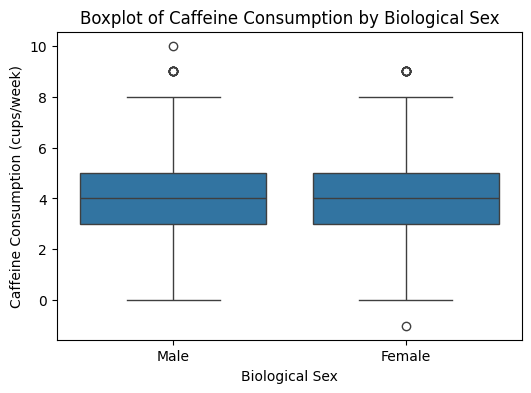

In [50]:
# Plot boxplot

plt.figure(figsize=(6,4))
sns.boxplot(
    data=annotations,
    x="isFemale",
    y="CaffeineConsumption"
)
plt.xticks([0,1], ["Male", "Female"])
plt.xlabel("Biological Sex")
plt.ylabel("Caffeine Consumption (cups/week)")
plt.title("Boxplot of Caffeine Consumption by Biological Sex")
plt.show()

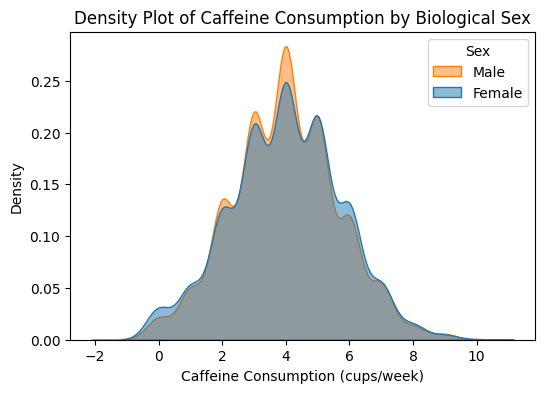

In [51]:
# Plot density plot

plt.figure(figsize=(6,4))
sns.kdeplot(
    data=annotations,
    x="CaffeineConsumption",
    hue="isFemale",
    common_norm=False,
    fill=True,
    alpha=0.5
)
plt.legend(title="Sex", labels=["Male", "Female"])
plt.xlabel("Caffeine Consumption (cups/week)")
plt.title("Density Plot of Caffeine Consumption by Biological Sex")
plt.show()

### ii. Use linear regression to test relationship between caffeine consumption and biological sex

In [68]:
# Linear regression

lr_df = annotations[["CaffeineConsumption", "isFemale"]].dropna()
lr_X = lr_df["isFemale"].map({True: 1, False: 0})
lr_y = lr_df["CaffeineConsumption"]

# Add constant for intercept
lr_X = sm.add_constant(lr_X)

# Fit OLS regression
lr_model = sm.OLS(lr_y, lr_X).fit()

# Show regression summary
# print(lr_model.summary())
print("Intercept: " + str(round(lr_model.params.const, 3)))
print("Slope: " + str(round(lr_model.params.isFemale, 3)))
print("R^2: " + str(lr_model.rsquared))

Intercept: 3.992
Slope: -0.015
R^2: 1.8596649948521282e-05


We should not include biological sex as a covariate in our analysis because it has virtually no effect on caffeine consumption, given the very low R^2 value.

## 4b. Population structure

### i. Calculate principal components of genotype matrix and plot 1st and 2nd PCs